# Fantasy Hockey Draft List Generator
** Final Project for DSE200x by Jeff Puuri **

Abstract: In 2017, it was estimated that there were over 50 million participants in online fantasy sports.  Participation in fantasy sports is a leisure activity, but many play for money as well as pride.

Drafting the best team at the start of each season is a major key to a successful season as measured by winning one's league, or finishing 'in the money' (usually the top 3 spots).  In helping participants prepare for a draft, many online leagues provide a suggested draft list, based on 'expert' advice, that ranks sports players' projected performance in the upcoming season that rely mainly on last year's player stats only.  It can be shown, based on average draft position, that league-provided suggested draft lists are the predominant source for draft selections.

Are these league-provided draft lists, the best source for one's draft choices?  Or is it possible to apply data science to create an improved draft list of players, based on more than just last years stats, that can provide a fantasy participant with an advantage at draft time over those using the draft list provided by the online fantasy host?

The goal in drafting a better team is to give one a better chance of their team finishing the season in the top spots, providing enhanced enjoyment, pride, and possible winnings in leagues that play for money.

This project study will produce a model for Fantasy Hockey using Yahoo Sports, the online service in which I have participated with same league for over ten years.  Therefore I will use the same statistical categories that are used by my league.  Although the model produced by this study is specific to the sport of hockey and a certain set of statsitical categories used by my leagues, I would like to demonstrate that this approach could be extended to other fantasy sports and the statistical categories defined for a participant's particular league.

One other note is that this study is geared towards season-long fantasy leagues, and not daily matchups that are becoming popular.

In [89]:
# import libraries to use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
dataFolder = 'D:/PjtData/4_PD/edX_DSE200x/wk10_FinalPjt/'

## Import Datasets
The next step is to import the datasets that will be used in the analysis.  One set is going to contain the predicted and actual rankings from Yahoo Sports for all players for the 2017-18 season (ranks).  The other contains the player statistics for 2004-2017 from Hockey-Reference.com that has been cleansed by a user through Kaggle (stats).  Finally we have the final stats for the 2017-18 season that I downloaded myself from Hockey-Reference.com into a csv file (stats18).


In [90]:
statsFile = 'NHLKaggleStats.csv'
ranksFile = 'YahooPlayerRanks.csv'
stats18File = 'NHLHockeyRef18.csv'
statsDF = pd.read_csv(dataFolder + statsFile)
ranksDF = pd.read_csv(dataFolder + ranksFile)
statsDF18 = pd.read_csv(dataFolder + stats18File)

## Remove unnecessary columns - Ranks
Each of the raw datasets contains statistical columns that are not part of the Yahoo Fantasy Hockey scoring criteria, therefore they can be removed to unclutter upcoming dataframe displays.  The following columns are considered for the scoring criteria: G = Goals, A = Assists, PM = Plus/Minus, PIM = Penalties in Minutes, PPP=Power Play Points, GWG = Game Winning Goals, SOG = Shots on Goal, HIT = Hits, BLK = Blocked shots.  We need to keep the GP = Games Played column for normalizing stats in a later step, and the PreSeasonRank and EndSeasonRank columns for comparing the model results.  We also keep PlayerName, Team, and Pos(ition) for identification purposes in visualizations and reports.

In [91]:
ranksDF.columns

Index(['PlayerName', 'Team', 'Pos', 'GP', 'PreSeasonRank', 'EndSeasonRank',
       'TOIperGP', 'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK'],
      dtype='object')

In [92]:
del(ranksDF['TOIperGP'])
ranksDF.columns

Index(['PlayerName', 'Team', 'Pos', 'GP', 'PreSeasonRank', 'EndSeasonRank',
       'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK'],
      dtype='object')

## Remove unnecessary columns - Stats
Keep the same corresponding columns from the Kaggle/Hockey Reference sources, and then rename the columns to align with the Yahoo naming

In [93]:
statsDF.columns

Index(['HockeyRefID', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS',
       'PM', 'PIM', 'PS', 'EVG', 'PPG', 'SHG', 'GWG', 'EVA', 'PPA', 'SHA',
       'SOG', 'SPCT', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FOPCT',
       'HART', 'Votes', 'Season'],
      dtype='object')

In [94]:
statsDF['PPP'] = statsDF['PPG'] + statsDF['PPA']
statsDF.drop(['Age', 'PTS', 'PS', 'EVG', 'PPG', 'SHG', 'EVA', 'PPA', 'SHA', 'SPCT', 'TOI', 'ATOI', 'FOW', 'FOL', 'FOPCT', 'HART', 'Votes'], axis=1, inplace=True)
statsDF.rename({'Player':'PlayerName', 'Tm':'Team'}, axis='columns', inplace='True')
statsDF = statsDF[['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season']]
statsDF.columns

Index(['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM',
       'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season'],
      dtype='object')

In [95]:
statsDF18.columns

Index(['HockeyRefID', 'Player', 'Age', 'Tm', 'Pos', 'GP', 'G', 'A', 'PTS',
       'PM', 'PIM', 'PS', 'EVG', 'PPG', 'SHG', 'GWG', 'EVA', 'PPA', 'SHA',
       'SOG', 'SPCT', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FOPCT'],
      dtype='object')

In [96]:
statsDF18['PPP'] = statsDF18['PPG'] + statsDF18['PPA']
statsDF18['Season'] = 2018
statsDF18.drop(['Age', 'PTS', 'PS', 'EVG', 'PPG', 'SHG', 'EVA', 'PPA', 'SHA', 'SPCT', 'TOI', 'ATOI', 'FOW', 'FOL', 'FOPCT'], axis=1, inplace=True)
statsDF18.rename({'Player':'PlayerName', 'Tm':'Team'}, axis='columns', inplace='True')
statsDF18 = statsDF18[['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season']]
statsDF18.columns

Index(['HockeyRefID', 'PlayerName', 'Team', 'Pos', 'GP', 'G', 'A', 'PM', 'PIM',
       'PPP', 'GWG', 'SOG', 'HIT', 'BLK', 'Season'],
      dtype='object')

In [97]:
# Slice the stats dataset to contain rows for just the seasons we need (2015-2017)
statsSeasons = [2015, 2016, 2017]
statsDF = statsDF[statsDF['Season'].isin(statsSeasons)]

In [98]:
statsDF.shape

(2668, 15)

## How good are the 'Expert' Rankings?
Online leagues, including Yahoo, provide a ranking list, from 1 to n, with 1 being the best, based on their projections for player performance in the upcoming season based on scoring categories.  Per Yahoo on how they make their determinations: "(Keep in mind these are the “x-rankings” for the players, i.e. the expert ranking based on last season’s performance and predictions for this season. This is the ranking used in the auto draft.)"  Note that the ranking is mainly based on last year's performance.  [Another source](https://www.reddit.com/r/fantasybball/comments/25b9oc/how_does_yahoo_or_other_fantasy_sites_calculate/) reports the evaluation of last year's performance is based on what is called a z-score.  First, we will see how well the expert ranking for each player for this past season translated to their actual ranking by the end of the season.  Then, I would like to see if using a linear regression using the data from the past three seasons would have provided a preseason ranking that resulted in a better correlation.

In the Yahoo statistics for each player, they provide a column for the pre-season ranking and the current ranking.  Since the NHL season has recently concluded, the dataset I downloaded will show how well the pre-season 'expert' rankings held up for this past season.  I renamed the current ranking column as reprted by Yahoo to EndSeasonRank to reflect this.  As you can see from the listing of the top 20 preseason ranks, who are typically drafted in the early rounds, some of the predictions were not too far off, but others are pretty bad.  This is just a subjective scan of the data right now.  After this, look at the statistical analysis of how close.

In [99]:
ranksDF.head(20)

,PlayerName,Team,Pos,GP,PreSeasonRank,EndSeasonRank,G,A,PM,PIM,PPP,GWG,SOG,HIT,BLK
0,Connor McDavid,Edm,C,82,1,8,41,67,20,26,20,7,274,28,46
1,Sidney Crosby,Pit,C,82,2,11,29,60,0,46,38,6,247,75,36
2,Patrick Kane,Chi,RW,82,3,117,27,49,-20,32,22,4,285,18,14
3,Auston Matthews,Tor,C,62,4,93,34,29,25,12,13,5,187,16,61
4,Brent Burns,SJ,D,82,6,29,12,55,-16,46,27,2,332,79,136
5,Vladimir Tarasenko,StL,RW,80,7,39,33,33,15,17,16,5,306,89,37
6,Alex Ovechkin,Was,LW,82,8,3,49,38,3,32,31,7,355,139,21
7,Nikita Kucherov,TB,RW,80,9,6,39,61,15,42,36,7,279,31,15
8,Evgeni Malkin,Pit,C,78,10,2,42,56,16,87,38,7,239,48,32
9,Jack Eichel,Buf,C,67,11,181,25,39,-25,32,20,4,246,52,35


Inthe rankings dataset, I only downloaded for a union of the top 100 preseason and top 100 endseason rankings.  There are over 900 players total in the NHL, but only the top players are eve drafted, so I limited the dataset for better visibility.

In [100]:
ranksDF.shape

(136, 15)

We learned about correlation in the course, so next will be a look at the correlation between Preseason and Endseason ranking, followed by a scatter plot to see what that looks like.

In [101]:
rankCorr = ranksDF['PreSeasonRank'].corr(ranksDF['EndSeasonRank'])
rankCorr

-0.06867974836107163

Wow, that is interesting to see a negative correlation between the two variables!  What does the scatter chart look like?  One would hope to see a grouping along the line defined by y = mx + b where m(slope) is 1, and b(y-intercept) is 0

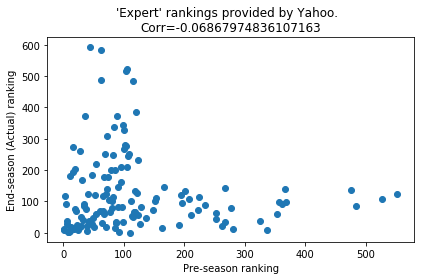

In [102]:
%matplotlib inline
plt.scatter(ranksDF['PreSeasonRank'],ranksDF['EndSeasonRank'])
# Label the axes
plt.xlabel('Pre-season ranking')
plt.ylabel('End-season (Actual) ranking')

#label the figure
plt.title('\'Expert\' rankings provided by Yahoo.  \nCorr={0}'.format(str(rankCorr)))
plt.tight_layout()
plt.savefig(dataFolder + 'expertranks.png')
plt.show()

As we can see, the plot doesn't reflect this at all, so the rest of the analysis will try to make an improvement.  It is interesting to note that on the draft page from the Yahoo web site, the average draft position corresponds very closely to the Preseason rank.  This means that a large majority of fantasy participants use this 'expert' ranking in their draft.  As we can see this may not be the best advice.  If we can find a better predictor, then one should be able to obtain a draft advantage.

# Does the Z-score reflect the current ranking?
As quoted previously, Yahoo uses the statistic called Z-score when computing the rankings.  In order to have a comparative, I need to confirm that the Z-score for the player's 2018 current year stats closesy correlates to their End of season ranking.

In [103]:
# Make a function that will return mean and std for a column so that we can compute the z-score
# for values in that column
def calcCatZ(df, dfcol):
    colMean = df[dfcol].mean()
    colStd = df[dfcol].std()
    return (colMean, colStd)

# Apply the function above to the statistical columns of interest
for curCol in ['G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK']:
    curMean, curStd = calcCatZ(statsDF18, curCol)
    statsDF18[curCol + 'Z'] = (statsDF18[curCol] - curMean) / curStd

# Compute the Total Z-score across all the columns
statsDF18['TotZ'] = statsDF18['GZ'] + statsDF18['AZ'] + statsDF18['PMZ'] + \
                    statsDF18['PIMZ'] + statsDF18['PPPZ'] + statsDF18['GWGZ'] + \
                    statsDF18['GWGZ'] + statsDF18['SOGZ'] + statsDF18['HITZ']

# Now rank the data frame by the Total Z,  Fingers crossed that it will correlate
# very closely for the End of Season ranking supplied by Yahoo
statsDF18['ZRnk'] = statsDF18['TotZ'].rank(ascending=False) # The higher total Z score, the better

# Now merge bank to the Yahoo rankings data frame so that we can see a side-by-side comparison
# of our computed Z-score ranking to the Yahoo-determined End of Season ranking
srnk18 = statsDF18.merge(ranksDF, on='PlayerName', how='left')

# We only saved the Yahoo rankings for the top players, but computed Z-Score
# ranking for all, so get rid of records without the Yahoo rankings
srnk18 = srnk18.dropna() 

# Save the dataframe sorte by Yahoo Rank for display purposes
srnk18.sort_values('EndSeasonRank', ascending=True, inplace=True) 

# Look at the top rows for a sanity check
srnk18.loc[:,['PlayerName', 'Team_x', 'EndSeasonRank', 'ZRnk']].head(15)

,PlayerName,Team_x,EndSeasonRank,ZRnk
448,Nathan MacKinnon,COL,1.0,1.0
714,Evgeni Malkin,PIT,2.0,2.0
782,Alex Ovechkin,WSH,3.0,3.0
506,Taylor Hall,NJD,4.0,5.0
399,Jamie Benn,DAL,5.0,6.0
276,Nikita Kucherov,TBL,6.0,4.0
39,Blake Wheeler,WPG,7.0,23.0
790,Connor McDavid,EDM,8.0,8.0
449,Tyler Seguin,DAL,9.0,13.0
300,Dustin Brown,LAK,10.0,11.0


## Not perfect, but how well does it correlate?
From the previous data frame glimpse, obviously the computed Z-score does not exactly line up with Yahoo's published End of season ranking for each player.  However, it does not appear near as far off as the Yahoo's Pre-Season Ranking.  But to confirm, we will compute the correlation and graph using another scatter plot for confirmation.

In [104]:
srnk18corr = srnk18['ZRnk'].corr(srnk18['EndSeasonRank'])
srnk18corr

0.7970790994912658

Interesting that we went from a negative correlation previously to almost 0.8, so although not perfect, a huge improvement.  I don't recall that we have learned in this class at what correlation value we can say is good enough to keep processing, but to complete this final project, I will subjectively decide the correlation value improvement is significant enough to warrant the next step. Just for visualization, let's look at the scatter plot of what this improved correlation looks like.

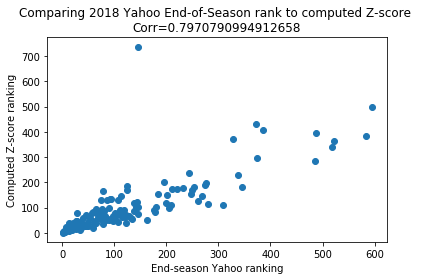

In [105]:
%matplotlib inline
plt.scatter(srnk18['EndSeasonRank'],srnk18['ZRnk'])
# Label the axes
plt.xlabel('End-season Yahoo ranking')
plt.ylabel('Computed Z-score ranking')

#label the figure
plt.title('Comparing 2018 Yahoo End-of-Season rank to computed Z-score \nCorr={0}'.format(str(srnk18corr)))
plt.tight_layout()
plt.savefig(dataFolder + '2018EndSeasonVsZRnks.png')
plt.show()

Wow - that's a big difference from the last plot.  Much better grouping on either side of a hypothetical line with a slope equation of y = 1 * x + 0

## Linear Regression Predictor
Now we will see if we can build a model that employs linear regression to predict a numeric Pre-season Ranking value that will outperform that provided by Yahoo.  Remember theirs is based on just last year's (2017) statistics plus the 'expert' prediction for 2018, that we saw might not be so expewrt.  Our linear regression model will be based on Z-scores for each category from the last three years.  Are players improving or regressing over the last several years?  Was last year an aberration?
Of course this analysis has potential flaws when it comes to how do you incorporate young players with less than three years experience, and how to account for a player having had a significant injury in one of the last the three years that would have depressed their season long stats for the year in which the injury occurred.  I don't know if I'll be able to incorporate that alternative analysis in this final project, but if the overall results show this model has good potential, then these situations would be potentially important to consider in further refining this model concept.

In [106]:
# Create Dataframes for use with the previously defined function used to compute Z-Scores,
# but now we have to do it for each season in a data frame that has multiple seasons
# I can probably do the same thing on slices, but keeping it simple stupid in order to finish
statsDFDict = {}
for yr in [2015, 2016, 2017]:
    statsDFDict[yr] = statsDF[statsDF['Season']==yr].copy()
    
    # Apply the function above to the statistical columns of interest
    for curCol in ['G', 'A', 'PM', 'PIM', 'PPP', 'GWG', 'SOG', 'HIT', 'BLK']:
        curMean, curStd = calcCatZ(statsDFDict[yr], curCol)
        statsDFDict[yr][curCol + 'Z'] = (statsDFDict[yr][curCol] - curMean) / curStd
        
    # Compute the Total Z-score across all the columns
    statsDFDict[yr]['TotZ'] = statsDFDict[yr]['GZ'] + statsDFDict[yr]['AZ'] + statsDFDict[yr]['PMZ'] + \
                              statsDFDict[yr]['PIMZ'] + statsDFDict[yr]['PPPZ'] + statsDFDict[yr]['GWGZ'] + \
                              statsDFDict[yr]['GWGZ'] + statsDFDict[yr]['SOGZ'] + statsDFDict[yr]['HITZ']

    # Now rank the data frame by the Total Z,  Fingers crossed that it will correlate
    # very closely for the End of Season ranking supplied by Yahoo
    statsDFDict[yr]['ZRnk'] = statsDFDict[yr]['TotZ'].rank(ascending=False) # The higher total Z score, the better
statsDFDict[2015].sort_values('ZRnk', ascending=True)

,HockeyRefID,PlayerName,Team,Pos,GP,G,A,PM,PIM,PPP,...,AZ,PMZ,PIMZ,PPPZ,GWGZ,SOGZ,HITZ,BLKZ,TotZ,ZRnk
1789,ovechal01,Alex Ovechkin,WSH,LW,81,53,28,10,58,34,...,1.216809,1.050320,1.198161,4.201897,5.632449,4.452637,3.122901,-0.200159,31.934324,1.0
1806,pacioma01,Max Pacioretty,MTL,LW,80,37,30,38,32,11,...,1.376372,3.891361,0.214760,0.912314,5.057603,3.123530,0.599561,-0.056844,23.754648,2.0
1787,tavarjo01,John Tavares,NYI,C,82,38,48,5,46,31,...,2.812445,0.542991,0.744284,3.772821,3.907911,2.780534,-0.356999,-0.080730,21.752514,3.0
1805,nashri01,Rick Nash,NYR,LW,79,42,27,29,36,12,...,1.137027,2.978169,0.366052,1.055339,3.907911,3.152112,-0.406476,-0.176273,20.214951,4.0
1786,bennja01,Jamie Benn,DAL,LW,82,35,52,1,64,23,...,3.131573,0.137128,1.425100,2.628618,2.758219,2.423247,0.830455,0.229786,19.375957,5.0
1828,laddan01,Andrew Ladd,WPG,LW,81,24,38,9,72,19,...,2.014627,0.948854,1.727685,2.056516,2.758219,2.008795,2.347758,-0.056844,18.594275,6.0
1831,wheelbl01,Blake Wheeler,WPG,RW,79,26,35,26,73,12,...,1.775282,2.673772,1.765508,1.055339,2.758219,2.294624,0.962394,0.325330,18.255104,7.0
1799,stamkst01,Steven Stamkos,TBL,C,82,43,29,2,49,25,...,1.296591,0.238594,0.857753,2.914669,2.758219,2.637619,0.286205,-0.176273,17.983846,8.0
1795,tarasvl01,Vladimir Tarasenko,STL,RW,77,37,36,27,31,18,...,1.855063,2.775238,0.176937,1.913491,2.758219,2.580454,-0.620878,-0.534561,17.718286,9.0
1808,toewsjo01,Jonathan Toews,CHI,C,81,28,38,30,36,17,...,2.014627,3.079635,0.366052,1.770466,3.333065,1.551467,-0.225060,-0.582333,17.673210,10.0


In [107]:
statsDFDict[2016].sort_values('ZRnk', ascending=True)

,HockeyRefID,PlayerName,Team,Pos,GP,G,A,PM,PIM,PPP,...,AZ,PMZ,PIMZ,PPPZ,GWGZ,SOGZ,HITZ,BLKZ,TotZ,ZRnk
902,ovechal01,Alex Ovechkin,WSH,LW,79,50,21,21,53,24,...,0.698465,2.460855,1.051798,2.769879,3.671961,4.488252,2.797736,-0.115986,26.583701,1.0
893,paveljo01,Joe Pavelski,SJS,C,82,38,40,25,30,28,...,2.213301,2.920068,0.156745,3.341060,5.304079,2.021142,1.445080,0.681676,26.280491,2.0
888,kanepa01,Patrick Kane,CHI,RW,82,46,60,17,30,37,...,3.807864,2.001642,0.156745,4.626218,4.216000,2.914406,-0.462511,-0.430216,25.983207,3.0
890,crosbsi01,Sidney Crosby,PIT,C,80,36,49,19,42,24,...,2.930854,2.231249,0.623729,2.769879,4.216000,2.361433,0.456601,-0.091814,23.147707,4.0
889,bennja01,Jamie Benn,DAL,LW,82,41,48,7,64,30,...,2.851126,0.853610,1.479866,3.626651,2.039844,2.347254,1.601156,0.391617,20.763752,5.0
950,ekmanol01,Oliver Ekman-Larsson,ARI,D,75,21,34,-6,96,27,...,1.734932,-0.638833,2.725157,3.198265,3.671961,2.077857,1.566472,0.681676,19.602414,6.0
900,kopitan01,Anze Kopitar,LAK,C,81,25,49,34,16,18,...,2.930854,3.953298,-0.388070,1.913107,3.671961,1.354738,0.248501,0.633333,19.416943,7.0
963,byfugdu01,Dustin Byfuglien,WPG,D,81,19,34,4,119,17,...,1.734932,0.509200,3.620210,1.770312,2.583883,2.347254,2.745710,1.600196,19.257049,8.0
928,simmowa01,Wayne Simmonds,PHI,RW,81,32,28,-7,147,21,...,1.256562,-0.753636,4.709840,2.341493,2.039844,2.092036,2.225458,0.125730,18.827450,9.0
891,thornjo01,Joe Thornton,SJS,C,82,19,63,25,54,29,...,4.047049,2.920068,1.090713,3.483856,2.583883,0.560726,-0.271752,-0.212672,18.360091,10.0


In [108]:
statsDFDict[2017].sort_values('ZRnk', ascending=True)

,HockeyRefID,PlayerName,Team,Pos,GP,G,A,PM,PIM,PPP,...,AZ,PMZ,PIMZ,PPPZ,GWGZ,SOGZ,HITZ,BLKZ,TotZ,ZRnk
5,marchbr03,Brad Marchand,BOS,LW,80,39,46,18,81,24,...,2.613061,1.863847,2.351176,2.753529,3.739059,2.028985,-0.167788,-0.105332,22.574414,1.0
20,ovechal01,Alex Ovechkin,WSH,LW,82,33,36,6,50,26,...,1.829381,0.648354,1.055313,3.037434,3.183177,3.269538,2.837256,-0.249231,22.000117,2.0
0,mcdavco01,Connor McDavid,EDM,C,82,30,70,27,26,27,...,4.493893,2.775466,0.052064,3.179386,2.627295,2.385466,-0.477398,-0.249231,20.271455,3.0
4,kucheni01,Nikita Kucherov,TBL,RW,74,40,45,13,38,32,...,2.534693,1.357391,0.553689,3.889149,3.183177,2.314170,-0.550248,-0.465079,20.234850,4.0
8,burnsbr01,Brent Burns,SJS,D,82,29,47,19,40,25,...,2.691429,1.965138,0.637293,2.895481,2.627295,3.369353,0.160035,2.460868,19.465139,5.0
26,carteje01,Jeff Carter,LAK,C,82,32,34,2,41,22,...,1.672645,0.243190,0.679095,2.469623,4.294941,2.371207,0.469646,-0.057365,19.335609,6.0
36,hoffmmi02,Mike Hoffman,OTT,LW,74,26,35,17,51,26,...,1.751013,1.762556,1.097115,3.037434,3.739059,2.000467,-0.349912,-0.441096,18.920113,7.0
1,crosbsi01,Sidney Crosby,PIT,C,75,44,45,17,24,25,...,2.534693,1.762556,-0.031540,2.895481,2.071412,2.442503,0.360371,-0.297197,18.341207,8.0
23,paveljo01,Joe Pavelski,SJS,C,81,29,39,11,34,22,...,2.064485,1.154809,0.386480,2.469623,3.183177,2.128800,1.270991,0.806029,18.333364,9.0
32,atkinca01,Cam Atkinson,CBJ,RW,82,35,27,13,22,21,...,1.124069,1.357391,-0.115144,2.327671,4.294941,2.228614,-0.495611,-0.129315,18.205694,10.0


## ML and Simple Stats with Z-scores
Now that we have the Z-scores for each player across the past three seasons, it is possible to perform the linear regression to predict a number for the upcoming season.  Along with that, I will look at the average, max, and min Z-score for each player over that span for comparative purposes.  It will also be interesting to see if one of those other stats might provide a better predictor as well.
In terms of linear regression, it will be interesting to see if the last three years is enough datapoints for an accurate predictor, hence the comparison to average, min, and max.  To that end, if a player does not have three years of experience, then we won't perform the linear regression, but use their aaverage value from the last one or two years.

In [109]:
# Create the empty dataframe that will populated with the Z-score stats
prd18 = pd.DataFrame(columns=['PlayerName', 'Yrs', 'ZPrd', 'ZAvg', 'ZMax', 'ZMin'])
# Reassemble the last three years dataframes back into a single unit
statsDF1517 = statsDFDict[2015].append([statsDFDict[2016], statsDFDict[2017]], ignore_index=True)
statsDF1517.shape

# Build up a new predictor dataframe with one row per player
# Use linear regression to populate a column called ZPrd if they have stats for the last three years
# Also build up columns for the Average, Min, and Max Z-Scores for each player over the last three seasons
players =[]
years = []
zavgs = []
zprds = []
zmaxs = []
zmins = []
for player in ranksDF['PlayerName']:
    #print(player)
    players.append(player)
    xtrn = statsDF1517[statsDF1517['PlayerName'] == player]['Season'].values.reshape(-1, 1)
    ytrn = statsDF1517[statsDF1517['PlayerName'] == player]['TotZ']
    years.append(ytrn.count())
    zavgs.append(ytrn.mean())
    zmaxs.append(ytrn.max())
    zmins.append(ytrn.min())
    # Only apply linear regression if they have three years of stats, otherwise we'll use the mean
    if ytrn.count() > 2:
        regr = LinearRegression()
        model = regr.fit(xtrn, ytrn)
        xtst = pd.DataFrame(np.array([2018])).values.reshape(-1, 1)
        zprd = regr.predict(xtst)[0]
        zprds.append(zprd)
    elif ytrn.count() > 0:
        zprds.append(ytrn.mean())
    # For rookies (promising rookies are ranked by Yahoo), apply nan, but then drop later
    # our draft strategy is to ignore rookies anyway because they are too unknown
    else:
        zprds.append(np.nan)
prd18['PlayerName'] = players
prd18['Yrs'] = years
prd18['ZPrd'] = zprds
prd18['ZAvg'] = zavgs
prd18['ZMax'] = zmaxs
prd18['ZMin'] = zmins
prd18.head(15)

,PlayerName,Yrs,ZPrd,ZAvg,ZMax,ZMin
0,Connor McDavid,2,13.671750,13.671750,20.271455,7.072044
1,Sidney Crosby,3,22.037299,18.896412,23.147707,15.200320
2,Patrick Kane,3,23.155855,18.400211,25.983207,12.230891
3,Auston Matthews,1,16.720441,16.720441,16.720441,16.720441
4,Brent Burns,3,23.929952,15.894309,19.465139,11.429497
5,Vladimir Tarasenko,3,17.664013,17.846999,18.287411,17.535300
6,Alex Ovechkin,3,16.905174,26.839381,31.934324,22.000117
7,Nikita Kucherov,3,23.073142,15.420188,20.234850,12.581896
8,Evgeni Malkin,3,20.077728,15.230400,18.096740,13.249412
9,Jack Eichel,2,9.746444,9.746444,9.860502,9.632386


In [110]:
# Merge back to the rankings dataframe so we can retrieve the Yahoo Predictions
prd18 = prd18.merge(ranksDF[['PlayerName', 'PreSeasonRank', 'EndSeasonRank']], on='PlayerName', how='left')

prd18['ZPrdRnk'] = prd18['ZPrd'].rank(ascending=False)
prd18['ZAvgRnk'] = prd18['ZAvg'].rank(ascending=False)
prd18['ZMaxRnk'] = prd18['ZMax'].rank(ascending=False)
prd18['ZMinRnk'] = prd18['ZMin'].rank(ascending=False)

# Now use the computed Z predictor and statistics to create rankings for each
zPrdCorr = prd18['ZPrdRnk'].corr(prd18['EndSeasonRank'])
zAvgCorr = prd18['ZAvgRnk'].corr(prd18['EndSeasonRank'])
zMaxCorr = prd18['ZMaxRnk'].corr(prd18['EndSeasonRank'])
zMinCorr = prd18['ZMinRnk'].corr(prd18['EndSeasonRank'])
zPrdCorr, zAvgCorr, zMaxCorr, zMinCorr

(0.018157176587776644,
 0.05809136905889947,
 0.10985820504553974,
 0.017168380658986886)

Interesting results, but not quite the improvement that we had hoped.  From earlier, we saw using the Yahoo preseason rankings was a -0.06 correlation.  Our prediction based on linear regression was just barely positive, meaning no correlation.  It seems as if taking the player's best season of the past three provides the biggest advantage at a 0.1 correlation.   Next, let's look at the plots to visualize these correlations.

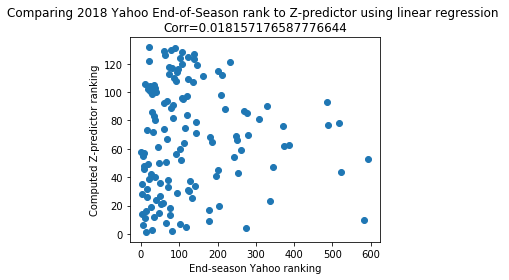

In [111]:
%matplotlib inline
plt.scatter(prd18['EndSeasonRank'],prd18['ZPrdRnk'])
# Label the axes
plt.xlabel('End-season Yahoo ranking')
plt.ylabel('Computed Z-predictor ranking')

#label the figure
plt.title('Comparing 2018 Yahoo End-of-Season rank to Z-predictor using linear regression \nCorr={0}'.format(str(zPrdCorr)))
plt.tight_layout()
plt.savefig(dataFolder + '2018EndSeasonVsZPrdRnks.png')
plt.show()

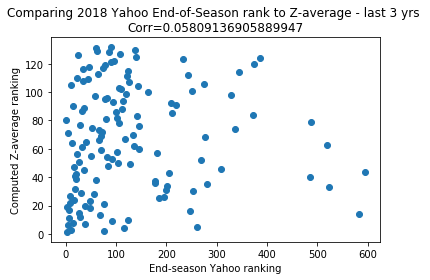

In [112]:
%matplotlib inline
plt.scatter(prd18['EndSeasonRank'],prd18['ZAvgRnk'])
# Label the axes
plt.xlabel('End-season Yahoo ranking')
plt.ylabel('Computed Z-average ranking')

#label the figure
plt.title('Comparing 2018 Yahoo End-of-Season rank to Z-average - last 3 yrs \nCorr={0}'.format(str(zAvgCorr)))
plt.tight_layout()
plt.savefig(dataFolder + '2018EndSeasonVsZAvgRnks.png')
plt.show()

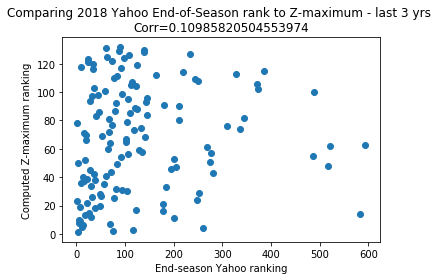

In [113]:
%matplotlib inline
plt.scatter(prd18['EndSeasonRank'],prd18['ZMaxRnk'])
# Label the axes
plt.xlabel('End-season Yahoo ranking')
plt.ylabel('Computed Z-maximum ranking')

#label the figure
plt.title('Comparing 2018 Yahoo End-of-Season rank to Z-maximum - last 3 yrs \nCorr={0}'.format(str(zMaxCorr)))
plt.tight_layout()
plt.savefig(dataFolder + '2018EndSeasonVsZMaxRnks.png')
plt.show()

## Conclusion
I wouldn't call this experiment a failure, yet.  I think there are some additional research steps one might be able to take to try improving these results.
One idea that I thought about is to look at more seasons for computing the linear regression.  I would also like to tackle this problem some more when we learn more about statistics in the upcoming class to see if there might be some other techniques that could lead to improvement.  For the sake of this project, I think I satisfied the objective given the scope of the assignment.